In [235]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage as dlinkage
from imblearn.over_sampling import RandomOverSampler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, classification_report
from keras.layers import Input, Dense, Lambda
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras import backend as K
import joblib

In [236]:
df = pd.read_csv('cleaning_data.csv')
df.head()

,ID,Year_Of_Birth,Academic_Level,Income,Registration_Time,Recency,Liquor,Vegetables,Pork,Seafood,...,Complain,Gender,Phone,Year_Register,Month_Register,Total_Purchase,Payment_Method,Age,Status,Children
0,1001,1994.0,Graduation,61074.0,2021-08-17,37.0,790.0,2.0,133.0,0.0,...,0.0,Other,8.412036e+10,2021.0,8.0,31.0,Card,30.0,Married,1
1,1002,1989.0,Graduation,60093.0,2022-06-26,92.0,503.0,14.0,109.0,16.0,...,0.0,Male,8.494833e+10,2022.0,6.0,21.0,Mobile,35.0,Married,1
2,1005,1978.0,Master,79689.0,2022-05-12,65.0,312.0,28.0,640.0,180.0,...,0.0,Female,8.444028e+10,2022.0,5.0,27.0,Online,46.0,Single,0
3,1006,1987.0,Master,41021.0,2021-12-30,12.0,15.0,9.0,9.0,6.0,...,0.0,Female,8.494006e+10,2021.0,12.0,7.0,Online,37.0,Together,1
4,1007,1996.0,PhD,57333.0,2021-09-22,55.0,942.0,16.0,397.0,76.0,...,0.0,Male,8.433939e+10,2021.0,9.0,33.0,Card,28.0,Divorced,1


In [237]:
# Drop meta data columns that cannot be used in unsupervised learning models
df = df.drop(columns=['ID', 'Phone', 'Year_Of_Birth', 'Registration_Time', 'Year_Register'])

In [238]:
df['TotalAccepted'] = df[['Promo_10', 'Promo_20', 'Promo_30', 'Promo_50']].sum(axis=1)

In [239]:
df['TotalSpent'] = df[['Seafood', 'Pork', 'Vegetables', 'Candy', 'Liquor', 'Jewellery']].sum(axis=1)

In [240]:
df['TotalPurchases'] = df[['Num_Deals_Purchases', 'Num_Catalog_Purchases', 'Num_Store_Purchases', 'Num_Web_Purchases']].sum(axis=1)

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Academic_Level         2236 non-null   object 
 1   Income                 2236 non-null   float64
 2   Recency                2236 non-null   float64
 3   Liquor                 2236 non-null   float64
 4   Vegetables             2236 non-null   float64
 5   Pork                   2236 non-null   float64
 6   Seafood                2236 non-null   float64
 7   Candy                  2236 non-null   float64
 8   Jewellery              2236 non-null   float64
 9   Num_Deals_Purchases    2236 non-null   float64
 10  Num_Web_Purchases      2236 non-null   float64
 11  Num_Catalog_Purchases  2236 non-null   float64
 12  Num_Store_Purchases    2236 non-null   float64
 13  Num_Web_Visits_Month   2236 non-null   float64
 14  Promo_30               2236 non-null   float64
 15  Prom

In [242]:
df1 = df.copy()

In [243]:
# Create a list of category columns in the new dataset
cate_col_lst = list(df1.select_dtypes(include='object').columns)
cate_col_lst

['Academic_Level', 'Gender', 'Payment_Method', 'Status']

In [244]:
df1 = df.copy()

# Encoded categorial using label encoder technique
label_encoder = LabelEncoder()
categorical_features = df1.select_dtypes('object').columns
for feature in categorical_features:
  df1[feature] = label_encoder.fit_transform(df1[feature])
df1.tail()

,Academic_Level,Income,Recency,Liquor,Vegetables,Pork,Seafood,Candy,Jewellery,Num_Deals_Purchases,...,Gender,Month_Register,Total_Purchase,Payment_Method,Age,Status,Children,TotalAccepted,TotalSpent,TotalPurchases
2231,1,22010.0,51.0,12.0,4.0,9.0,3.0,0.0,8.0,2.0,...,1,6.0,7.0,3,32.0,3,1,0.0,36.0,7.0
2232,1,38361.0,74.0,40.0,2.0,56.0,20.0,8.0,14.0,3.0,...,0,12.0,10.0,1,38.0,3,1,0.0,140.0,10.0
2233,1,56628.0,30.0,480.0,7.0,82.0,7.0,17.0,171.0,2.0,...,1,3.0,20.0,2,34.0,2,1,1.0,764.0,20.0
2234,1,75330.0,94.0,556.0,84.0,257.0,93.0,61.0,61.0,4.0,...,2,10.0,29.0,3,31.0,1,2,0.0,1112.0,29.0
2235,1,56243.0,26.0,348.0,2.0,35.0,4.0,3.0,7.0,6.0,...,1,12.0,20.0,3,30.0,2,3,0.0,399.0,20.0


### Correlation

In [245]:
# The common scaler used for all numeric columns when performing machine learning models
scaler = StandardScaler()

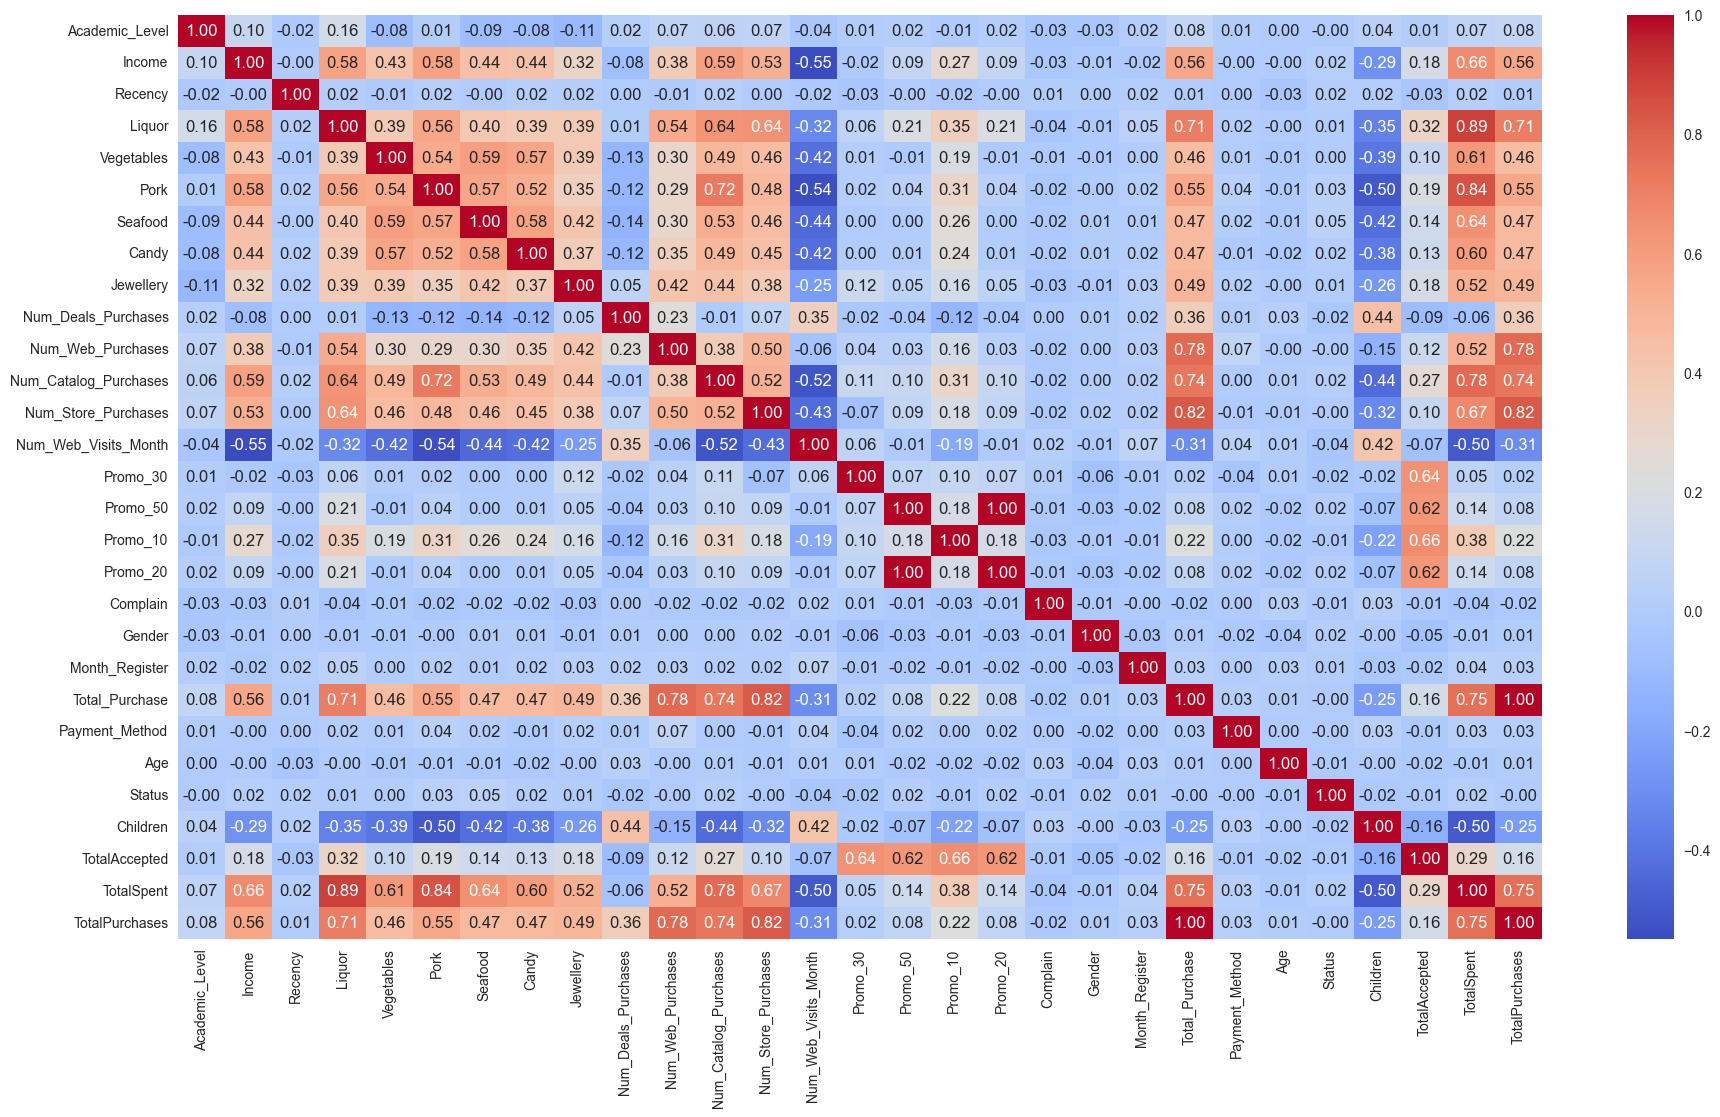

In [246]:
# Set the figure size
plt.figure(figsize=(22, 12))
correlation_matrix = df1.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [247]:
df1_scaled = scaler.fit_transform(df1)
df1_scaled

array([[-0.79199161,  0.35316858, -0.41961338, ..., -0.3482103 ,
         0.82434683,  2.10239831],
       [-0.79199161,  0.31400302,  1.48031864, ..., -0.3482103 ,
         0.21508938,  0.80026474],
       [ 0.39972659,  1.09635604,  0.54762474, ..., -0.3482103 ,
         1.17794857,  1.58154488],
       ...,
       [-0.79199161,  0.17566595, -0.66142291, ...,  1.77910726,
         0.25825204,  0.67005138],
       [-0.79199161,  0.92232681,  1.54940708, ..., -0.3482103 ,
         0.83596755,  1.84197159],
       [-0.79199161,  0.16029516, -0.79959979, ..., -0.3482103 ,
        -0.34768521,  0.67005138]])

### MODELING

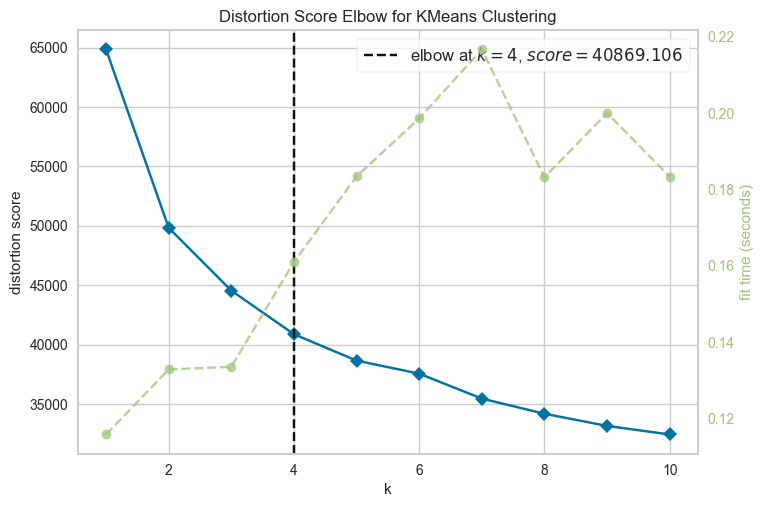

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [248]:
# Using Elbow method to find hyperparameter k
elbow_method = KElbowVisualizer(KMeans(), k=(1,11))
elbow_method.fit(df1_scaled)
elbow_method.show()

In [249]:
# Choose k=5 by using  method
kmeans_model = KMeans(n_clusters=4)
kmeans_model.fit(df1_scaled)

KMeans(n_clusters=4)

In [250]:
# To output the labels of the training set (scaled_data), use .labels_
kmeans_model.labels_

array([3, 3, 1, ..., 3, 3, 3])

In [251]:
# To predict the labels of the testing set (assuming it's scaled_data), use .predict
kmeans_model.predict(df1_scaled)

array([3, 3, 1, ..., 3, 3, 3])

In [252]:
# To output the centroids, use .cluster_centers_
kmeans_model.cluster_centers_.shape

(4, 29)

In [253]:
pca = PCA(n_components=3)  # Use 3 principal components
pca_df = pd.DataFrame(pca.fit_transform(df1_scaled), columns=['pca_1', 'pca_2', 'pca_3'])  # Create dataframe with 3 principal components

In [254]:
pca3_kmeans_model = KMeans(4)
pca3_kmeans_model.fit_predict(df1_scaled)
pca3_df_kmeans = pd.concat([pca_df, pd.DataFrame({'cluster': pca3_kmeans_model.labels_})], axis=1)

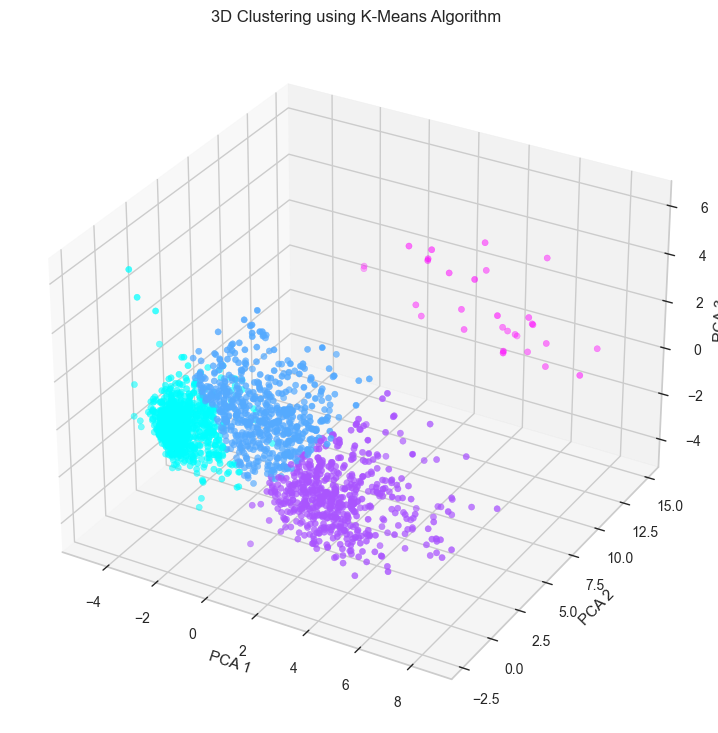

In [255]:
# 3D Visualization
plt.figure(figsize=(16, 9))
ax = plt.subplot(projection="3d")
ax.scatter(pca3_df_kmeans.pca_1, pca3_df_kmeans.pca_2, pca3_df_kmeans.pca_3, c=pca3_kmeans_model.labels_, cmap="cool")
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title("3D Clustering using K-Means Algorithm")
plt.show()

In [256]:
cluster_labels = pca3_kmeans_model.fit_predict(pca3_df_kmeans)
silhouette1 = silhouette_score(pca3_df_kmeans, cluster_labels)

# Evaluate K-means model based on Inertia value
print(f'Inertia = {pca3_kmeans_model.inertia_:.4f}')

# Evaluate K-means model based on Silhouette score
print(f'Silhouette score = {silhouette1}')

Inertia = 6852.1835
Silhouette score = 0.5047796642041892


In [257]:
# Result
centroids = pca3_kmeans_model.cluster_centers_
pca3_df_kmeans['cluster'] = pca3_kmeans_model.labels_
print('Size of clusters:', Counter(pca3_kmeans_model.labels_))
print('02 largest clusters:', Counter(pca3_kmeans_model.labels_).most_common(2))

Size of clusters: Counter({1: 1040, 3: 601, 0: 565, 2: 30})
02 largest clusters: [(1, 1040), (3, 601)]


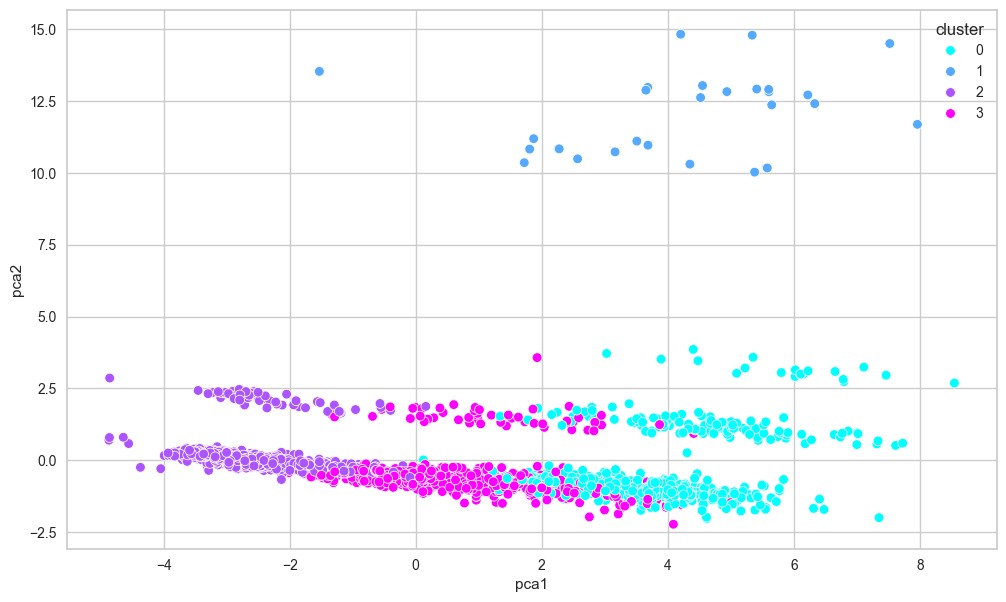

In [258]:
pca = PCA(n_components=2)
pca.fit(df1_scaled)
pca_df = pd.DataFrame(pca.transform(df1_scaled), columns=["pca1", "pca2"])

pca2_kmeans_model = KMeans(4)
pca2_kmeans_model.fit_predict(df1_scaled)
pca2_df_kmeans = pd.concat([pca_df, pd.DataFrame({'cluster': pca2_kmeans_model.labels_})], axis=1)

plt.figure(figsize=(12, 7))
ax = plt.subplot()
ax = sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=pca2_df_kmeans, palette="cool")
plt.show()

In [259]:
# Result
centroids = pca2_kmeans_model.cluster_centers_
pca2_df_kmeans['cluster'] = pca2_kmeans_model.labels_
print('Size of clusters:', Counter(pca2_kmeans_model.labels_))
print('02 largest clusters:', Counter(pca2_kmeans_model.labels_).most_common(2))

Size of clusters: Counter({2: 1038, 3: 607, 0: 561, 1: 30})
02 largest clusters: [(2, 1038), (3, 607)]


In [260]:
cluster_labels = pca2_kmeans_model.fit_predict(pca2_df_kmeans)
silhouette2 = silhouette_score(pca2_df_kmeans, cluster_labels)

# Evaluate K-means model based on Inertia value
print(f'Inertia = {pca2_kmeans_model.inertia_:.4f}')

# Evaluate K-means model based on Silhouette score
print(f'Silhouette score = {silhouette2}')

Inertia = 4070.8978
Silhouette score = 0.6033349077709034


In [261]:
print(f'Silhouette score of K-means PCA = 3: {(silhouette1)*100:.2f}%')
print(f'Silhouette score of K-means PCA = 2: {(silhouette2)*100:.2f}%')

Silhouette score of K-means PCA = 3: 50.48%
Silhouette score of K-means PCA = 2: 60.33%


> So with the same number of clusters k=4, we observe that the Silhouette score of the K-means model with PCA=3 is less effective than the K-means model with PCA=2 -> Our team choosing PCA=2 to label the cluster index into the original dataframe df2.

In [262]:
kmeans_2_df = df.copy()
clusters = pca2_kmeans_model.fit_predict(df1_scaled)
kmeans_2_df['Cluster'] = clusters
kmeans_2_df

,Academic_Level,Income,Recency,Liquor,Vegetables,Pork,Seafood,Candy,Jewellery,Num_Deals_Purchases,...,Month_Register,Total_Purchase,Payment_Method,Age,Status,Children,TotalAccepted,TotalSpent,TotalPurchases,Cluster
0,Graduation,61074.0,37.0,790.0,2.0,133.0,0.0,28.0,152.0,7.0,...,8.0,31.0,Card,30.0,Married,1,0.0,1105.0,31.0,1
1,Graduation,60093.0,92.0,503.0,14.0,109.0,16.0,6.0,90.0,2.0,...,6.0,21.0,Mobile,35.0,Married,1,0.0,738.0,21.0,1
2,Master,79689.0,65.0,312.0,28.0,640.0,180.0,37.0,121.0,1.0,...,5.0,27.0,Online,46.0,Single,0,0.0,1318.0,27.0,0
3,Master,41021.0,12.0,15.0,9.0,9.0,6.0,16.0,12.0,2.0,...,12.0,7.0,Online,37.0,Together,1,0.0,67.0,7.0,3
4,PhD,57333.0,55.0,942.0,16.0,397.0,76.0,58.0,176.0,11.0,...,9.0,33.0,Card,28.0,Divorced,1,0.0,1665.0,33.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,Graduation,22010.0,51.0,12.0,4.0,9.0,3.0,0.0,8.0,2.0,...,6.0,7.0,Online,32.0,Together,1,0.0,36.0,7.0,3
2232,Graduation,38361.0,74.0,40.0,2.0,56.0,20.0,8.0,14.0,3.0,...,12.0,10.0,Cash,38.0,Together,1,0.0,140.0,10.0,3
2233,Graduation,56628.0,30.0,480.0,7.0,82.0,7.0,17.0,171.0,2.0,...,3.0,20.0,Mobile,34.0,Single,1,1.0,764.0,20.0,1
2234,Graduation,75330.0,94.0,556.0,84.0,257.0,93.0,61.0,61.0,4.0,...,10.0,29.0,Online,31.0,Married,2,0.0,1112.0,29.0,1


In [263]:
#cluster_means = kmeans_2_df.groupby('Cluster').mean()
#cluster_means

NHAN XET

The LinearRegression model is one of the simplest and most common machine learning models used for sales forecasting. It is based on linear regression, which attempts to establish a linear relationship between input features and output value.

In sales forecasting tasks, the LinearRegression model can be used to predict sales volume based on various factors such as price, advertising spend, number of visitors, etc. To do this, you need to prepare the data, train the model on the training dataset, and then use it to predict sales on the test dataset.



In [264]:
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [265]:
features = ['Age', 'Academic_Level', 'Status', 'Gender', 'Payment_Method', 'Children', 'TotalSpent']
X = kmeans_2_df[features]
y = kmeans_2_df['Cluster']

In [266]:
X

,Age,Academic_Level,Status,Gender,Payment_Method,Children,TotalSpent
0,30.0,Graduation,Married,Other,Card,1,1105.0
1,35.0,Graduation,Married,Male,Mobile,1,738.0
2,46.0,Master,Single,Female,Online,0,1318.0
3,37.0,Master,Together,Female,Online,1,67.0
4,28.0,PhD,Divorced,Male,Card,1,1665.0
...,...,...,...,...,...,...,...
2231,32.0,Graduation,Together,Male,Online,1,36.0
2232,38.0,Graduation,Together,Female,Cash,1,140.0
2233,34.0,Graduation,Single,Male,Mobile,1,764.0
2234,31.0,Graduation,Married,Other,Online,2,1112.0


In [267]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [268]:
# Xử lý dữ liệu không phải số
label_encoders = {}
categorical_features = ['Academic_Level', 'Status', 'Gender', 'Payment_Method']
for feature in categorical_features:
    le = LabelEncoder()
    X_resampled[feature] = le.fit_transform(X_resampled[feature])
    label_encoders[feature] = le

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [270]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [271]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [272]:
y_pred = model.predict(X_test)

In [273]:
from sklearn.metrics import classification_report

# Assuming model is your logistic regression model
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       208
           1       0.96      0.95      0.95       211
           2       1.00      1.00      1.00       194
           3       0.99      0.99      0.99       219

    accuracy                           0.98       832
   macro avg       0.98      0.98      0.98       832
weighted avg       0.98      0.98      0.98       832



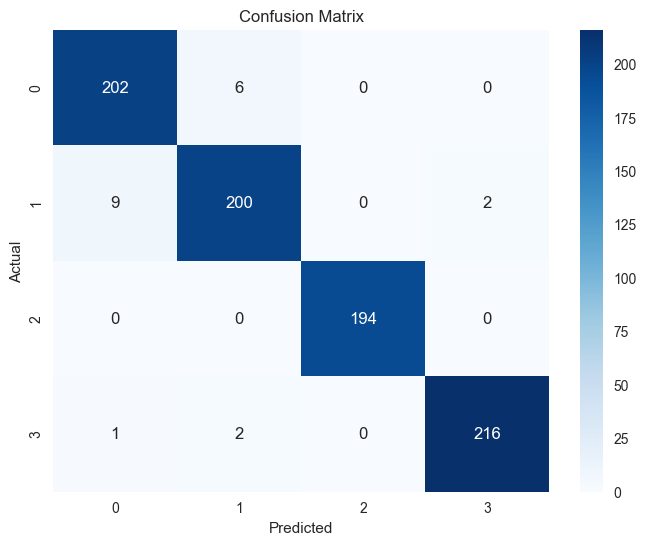

In [274]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [275]:
# Lưu mô hình đã huấn luyện
joblib.dump(model, 'rf_model.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

['label_encoders.joblib']

In [276]:
def get_user_input():
    while True:
        try:
            age = int(input("Enter your age: "))
            break
        except ValueError:
            print("Invalid input. Please enter a number for age.")

    while True:
        try:
            educationlvl = int(input("Enter your education level (1: 'Basic', 2: 'Graduation', 3: 'Master', 4: 'PhD'): "))
            if educationlvl not in [1, 2, 3, 4]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    while True:
        try:
            marriedstatus = int(input("Enter your marital status (1: 'Single', 2: 'Together', 3: 'Married', 4: 'Widow', 5: 'Divorced'): "))
            if marriedstatus not in [1, 2, 3, 4, 5]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    while True:
        try:
            gender = int(input("Enter your gender (1: 'Male', 2: 'Female', 3: 'Other'): "))
            if gender not in [1, 2, 3]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    while True:
        try:
            payment_method = int(input("Enter your payment method (1: 'Cash', 2: 'Card', 3: 'Mobile', 4: 'Online'): "))
            if payment_method not in [1, 2, 3, 4]:
                raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    while True:
        try:
            children = int(input("Enter the number of children: "))
            break
        except ValueError:
            print("Invalid input. Please enter a number for children.")

    while True:
        try:
            totalspent = int(input("Enter your total spent amount: "))
            break
        except ValueError:
            print("Invalid input. Please enter a number for total spent amount.")

    # Map inputs to corresponding categorical values
    education_map = {1: 'Basic', 2: 'Graduation', 3: 'Master', 4: 'PhD'}
    marital_status_map = {1: 'Single', 2: 'Together', 3: 'Married', 4: 'Widow', 5: 'Divorced'}
    gender_map = {1: 'Male', 2: 'Female', 3: 'Other'}
    payment_method_map = {1: 'Cash', 2: 'Card', 3: 'Mobile', 4: 'Online'}

    user_data = {
        'Age': age,
        'Academic_Level': education_map[educationlvl],
        'Status': marital_status_map[marriedstatus],
        'Gender': gender_map[gender],
        'Payment_Method': payment_method_map[payment_method],
        'Children': children,
        'TotalSpent': totalspent
    }

    return user_data

In [277]:
def predict_cluster(user_data):
    # Load the saved model and label encoders
    rf_model = joblib.load('rf_model.joblib')
    label_encoders = joblib.load('label_encoders.joblib')
    
    # Process the input data
    user_df = pd.DataFrame([user_data])
    for feature in categorical_features:
        le = label_encoders[feature]
        user_df[feature] = le.transform(user_df[feature])
    
    # Predict the cluster
    cluster_pred = rf_model.predict(user_df)
    return cluster_pred[0]

In [278]:
# Get input from the user
user_data = get_user_input()

# Predict cluster for the user
predicted_cluster = predict_cluster(user_data)
print(f"The user belongs to Cluster {predicted_cluster}")

The user belongs to Cluster 0
